In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import warnings
import geopandas as gpd
import pandas as pd
import regionmask

from cmip_preprocessing_funcs import *
import os
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import requests
import seaborn as sns
from joblib import dump
import h5py
import rioxarray
print("DONE")

ncpath = f'../Data/Fall 2023/US_LME_RFR_Preds_06-Oct-2023.nc'

ds = xr.open_dataset(ncpath)
ds = ds.rename({'Lat': 'lat', 
                'Lon': 'lon',
                'Time': 'time'})


/users/zacharys/.conda/envs/xesmf_env/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


DONE


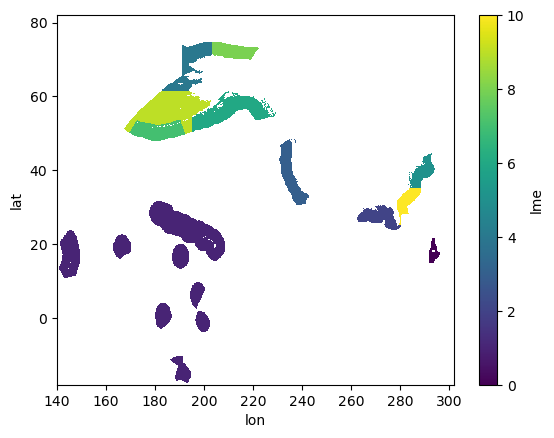

In [2]:
import rasterio
import rasterio.features
import geopandas as gpd
import xarray as xr
import numpy as np

shp_path = "../../Ships of Opportunity Coverage/Data/LME Boundaries/New EIWG LMEs/eiwg_boundaries_20230512_ZachS_ChangeLongto0_360.shp"
# Load shapefile
gdf = gpd.read_file(shp_path)

# Create an empty numpy array for the raster
raster_shape = (len(ds['lat']), len(ds['lon']))
raster_array = np.full(raster_shape, np.nan, dtype=np.float32)
# Reverse the latitude array for correct orientation
lat_reversed = ds['lat'][::-1]

# Define transformation with reversed latitude
transform = rasterio.transform.from_bounds(west=ds['lon'].min(), south=lat_reversed.min(), 
                                           east=ds['lon'].max(), north=lat_reversed.max(), 
                                           width=raster_shape[1], height=raster_shape[0])

# Rasterize each geometry
for idx, geom in enumerate(gdf.geometry[:11]): # :11 excludes Great Lakes
    rasterized = rasterio.features.rasterize([(geom, idx)], 
                                             out_shape=raster_shape, 
                                             fill=-999,  # Fill value for 'background'
                                             transform=transform)
    raster_array[rasterized == idx] = idx

# Create an xarray DataArray from the numpy array
lme_raster = xr.DataArray(raster_array, dims=('lat', 'lon'), coords={'lat': lat_reversed, 'lon': ds['lon']})

# Add to the dataset
ds['lme'] = lme_raster
ds['lme'].plot()

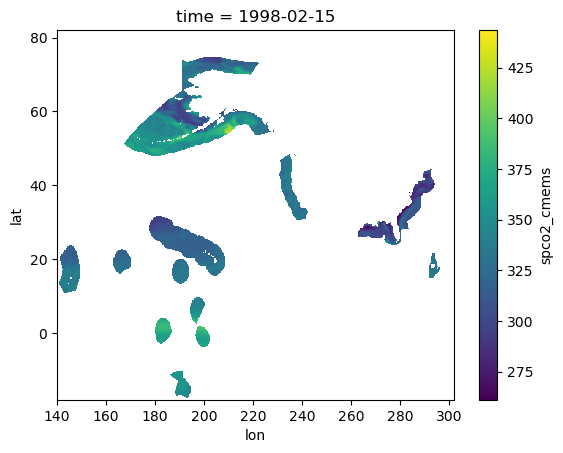

In [3]:
cmems_path = '../Data/CMEMS/CMEMS_complete_spco2.nc'
ds_cmems = xr.open_dataset(cmems_path)
ds_cmems = ds_cmems.rename({'latitude': 'lat', 
                           'longitude': 'lon'})


target_grid = xr.Dataset({
    'lat': (['lat'], ds['lat'].values),
    'lon': (['lon'], ds['lon'].values),
})

# Example of cropping ds_cmems to match ds bounds (modify lat/lon bounds as needed)
lat_bounds = ds['lat'].min(), ds['lat'].max()
lon_bounds = ds['lon'].min(), ds['lon'].max()


# Crop using the indices
ds_cmems_cropped = ds_cmems.isel(lat=slice(1, 401), lon=slice(1, 649))

# Create a regridder
regridder = xe.Regridder(ds_cmems_cropped, target_grid, 'bilinear', ignore_degenerate = True)

# Perform the regridding
ds_cmems_regridded = regridder(ds_cmems_cropped)

# Copy the time variable from ds_cmems_regridded to ds
ds['time'] = ds_cmems_regridded['time']
ds['spco2_cmems'] = ds_cmems_regridded['spco2']

ds['spco2_cmems'] = ds['spco2_cmems'].where(~ds['lme'].isnull())

# Extract spco2_cmems and apply unit conversion
ds['spco2_cmems'] = ds['spco2_cmems'] * 9.86923

ds['spco2_cmems'].isel(time = 1).plot()

## Calculate Distance from Coast

In [ ]:
import xarray as xr
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
from shapely.ops import nearest_points
import shapely

# Assuming the latitude and longitude coordinates are named 'lat' and 'lon'
latitudes = ds['lat']
longitudes = ds['lon']

# Load the coastline data
coastline_shapefile_path = '../Data/Coastlines/ne_10m_coastline.shp'
coastline = gpd.read_file(coastline_shapefile_path)

# Adjust the longitude values in the coastline dataset
coastline['geometry'] = coastline['geometry'].apply(lambda geom: shapely.affinity.translate(geom, xoff=360) if geom.bounds[0] < 0 else geom)

# Convert coastline GeoDataFrame to a MultiLineString for efficient distance calculations
coastline_multilinestring = coastline.geometry.unary_union

# Create a meshgrid of latitude and longitude points from the NetCDF file
lon, lat = np.meshgrid(longitudes.values, latitudes.values)
grid_points = [Point(lon, lat) for lon, lat in zip(np.ravel(lon), np.ravel(lat))]

# Calculate distance from each grid point to the nearest coastline
distances = np.array([nearest_points(point, coastline_multilinestring)[1].distance(point) for point in grid_points])

# Reshape the distances back to the original latitude-longitude grid shape
distance_array = distances.reshape(lon.shape)

# Add the distance_array as a new variable in the dataset
ds['dist'] = xr.DataArray(distance_array, dims=('lat', 'lon'), coords={'lat': latitudes, 'lon': longitudes})
ds['dist'] = ds['dist'].where(~ds['lme'].isnull())

# Mask out all discrepancies between LME dataset, CMEMS dataset, and Jon's original dataset
mask = xr.where(ds['spco2_cmems'].isel(time=0).notnull() & ds['lme'].notnull() & ds['SST'].isel(time = 0).notnull(), True, False)
ds_masked = ds.where(mask)

ds_masked['dist'].plot()


## Calculate SPCO2_CMEMS_STD

In [ ]:
warnings.filterwarnings('ignore', message='Degrees of freedom <= 0 for slice', category=RuntimeWarning)


ds_masked['month'] = ds_masked['time'].dt.month
# Initialize an empty DataArray to store the mapped standard deviations
std_mapped_to_months = xr.full_like(ds_masked['spco2_cmems'], fill_value=np.nan)

# Iterate through each month and assign the corresponding standard deviation
for month in range(1, 13):
    std_monthly_value = spco2_cmems_std_monthly.sel(month=month)
    std_mapped_to_months = xr.where(ds_masked['month'] == month, std_monthly_value, std_mapped_to_months)

# Assign the mapped standard deviation back to the dataset
ds_masked['spco2_cmems_std'] = std_mapped_to_months
ds_masked['spco2_cmems_std'].isel(time = 0).plot()

ds_masked.to_netcdf('../Data/Fall 2023/Predictors_and_CMEMS.nc')

In [ ]:
ds_masked['spco2_cmems_std'].isel(time = 12*2).plot(vmax = 30)

In [ ]:
import h5py
import xarray as xr
import numpy as np

path = '../Data/Fall 2023/socat_gridded_2023.mat'

with h5py.File(path, 'r') as file:
    lat = np.squeeze(np.array(file['SOCAT_grid/lat']))
    lon = np.squeeze(np.array(file['SOCAT_grid/lon']))
    time = np.squeeze(np.array(file['SOCAT_grid/month']))
    fco2 = np.array(file['SOCAT_grid/fco2_ave_wtd'])
    fco2_std = np.array(file['SOCAT_grid/fco2_std_wtd'])
    count_nobs = np.array(file['SOCAT_grid/fco2_count_nobs'])
    area = np.array(file['SOCAT_grid/area_km2'])
    n_months = np.array(file['SOCAT_grid/num_months'])
    fco2_grid_uncert = np.array(file['SOCAT_grid/fco2_grid_uncert'])
    print(file['SOCAT_grid'].keys())


# Create the xarray Dataset
socat_ds = xr.Dataset(
    data_vars={'fco2': (('time', 'lat', 'lon'), fco2),
              'fco2_std': (('time', 'lat', 'lon'), fco2_std),
              'count_nobs': (('time', 'lat', 'lon'), count_nobs),
              'area': (('lat', 'lon'), area),
              'n_months': (('lat', 'lon'), n_months),
              'fco2_grid_uncert': (('time', 'lat', 'lon'), fco2_grid_uncert)},
    coords={'time': time, 'lat': lat, 'lon': lon}
)
socat_ds['time'] = ds['time']
socat_ds.to_netcdf('../Data/Fall 2023/SOCAT.nc')